## Molecular Dynamics (MD) simulation of LJ particles in NVE ensemble

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

Following function will evaluate the forces on each particle. Only special thing to consider is usage of minimum image convention for distance calculation.

In [51]:
@jit(nopython=True)
def get_force(pos,boxl):
    sigma = 1.0
    eps   = 1.0
    r_cut = 4.0
    E_cut = 4*eps*((sigma/r_cut)**12 - (sigma/r_cut)**6)
    potnrg = 0.0
    f = np.zeros_like(pos)
    npart = len(pos)

    for i in range(len(pos)-1):
        for j in range(i+1, len(pos)):
            dpos = (pos[i]-pos[j])
            for comp in range(len(dpos)):
                if np.abs(dpos[comp]) > boxl/2.0:
                    dpos[comp] -= np.sign(dpos[comp])*boxl
            r = np.linalg.norm(dpos)
            if r <= r_cut:
                r2i = 1/(r*r)
                r6i = r2i**3
                fij = r2i*r6i*(r6i - 0.5)*dpos
                f[i] += fij
                f[j] -= fij
                potnrg += r6i*(r6i - 1) - E_cut
    f *= 48
    potnrg *= (4/npart)
    return f, potnrg

Following cell contains the function for executing MD simulation in NVE ensemble. We're using Velocity Verlet algorithm to integrate the equation of motion. See Eq.4.3.3 and 4.3.4 in the book. Here are they:

For position:
$r(t + \delta t) = r(t) + v(t)\delta t + \frac{f(t)}{2m}\delta t^2$

For velocity:
$v(t + \delta t) = v(t) + \frac{f(t + \delta t) + f(t)}{2m}\delta t$

In [62]:
@jit(nopython=True)
def MD_NVE(pos, vel, boxl, kT=1.0, steps=0, equib=0, sampl_freq=1):
    print("Running MD for", steps, "steps ...")
    npart = len(pos) # pos.shape[0]
    ndim = len(pos[0]) # pos.shape[1]

    dt = 0.005 # Adjustable parameter
    
    #nsample = int((steps - equib)/sampl_freq)
    nsample = steps
    
    traj_potnrg = np.zeros(nsample)
    traj_kinnrg = np.zeros(nsample)
    kT = np.zeros(nsample)
    
    traj_pos = np.zeros((nsample,npart,ndim))
    traj_vel = np.zeros_like(traj_pos)
    traj_force = np.zeros_like(traj_pos)
    
    traj_pos[0] = pos
    traj_vel[0] = vel
    traj_force[0], traj_potnrg[0] = get_force(pos,boxl)
    kT[0] = (traj_vel[0]**2).sum()/(3*npart)
    traj_kinnrg[0] = (traj_vel[0]**2).sum()/2
    
    for step in range(1,steps):
        # Velocity Verlet algorithm to integrate EOM
        traj_pos[step] = traj_pos[step-1] + traj_vel[step-1]*dt + (traj_force[step-1] * (dt**2))/2.0
        traj_pos[step] = np.mod(traj_pos[step],boxl) # Wrap particles due to PBC
        traj_force[step], traj_potnrg[step] = get_force(traj_pos[step],boxl)
        traj_vel[step] = traj_vel[step-1] + ((traj_force[step-1]+traj_force[step])*dt)/2
        
        if step < equib:
            # We rescale the velocity here to reach the target temperature
            vel_com = traj_vel[step].sum(axis=0)/npart # Velocity of centre of mass (to be removed)
            vel_sq = (traj_vel[step]**2).sum()/npart # Mean square velocity
            sf = np.sqrt(3*kT/vel_sq) # Scaling factor to fix target temperature

            traj_vel[step] -= vel_com
            traj_vel[step] *= sf

        kT[step] = (traj_vel[step]**2).sum()/(3*npart)
        traj_kinnrg[step] = (traj_vel[step]**2).sum()/(2*npart)
        
        if step%100 == 0:
            print("MD step = ", step)
        '''
        if ((step >= equib) and (step % sampl_freq == 0)):
            print("MC step:", step)
            traj_nrg[isampl] = potnrg
            traj_pos[isampl] = pos
            isampl += 1
        '''
    
    return traj_pos, traj_vel, traj_force,  traj_potnrg, traj_kinnrg, kT

In [63]:
@jit(nopython=True)
def steep(pos, boxl, steps=10, tol=1.0):
    for step in range(1,steps+1):
        f, potnrg = get_force(pos,boxl)
        maxf = f.max()
        if maxf > 10:
            alpha = 0.1/maxf
        else:
            alpha = 0.001

        pos += alpha*f
        pos = np.mod(pos,boxl) # Wrap particles due to PBC
        
        if step%10 == 0:
            print("SD step:", step, "Pot. Energy:", potnrg, "Max. force:", maxf)

        if maxf < tol: # Convergence is checked by max force value, not energy
            print("Steepest descent converged!")
            break
    return pos    

Let's prepare the system now!

In [65]:
#Initialise the size of simulation box, dimensions, number of particles and temperature
boxl = 5 # Unit of sigma
ndim = 3
npart = 128 # Number of particles
rho = npart/(boxl**ndim)
kT = 2.0

# Initialise with random coordinates followed by steepest descent ...
pos = np.random.random((npart,ndim))*boxl 

print("Running steepest descent energy minimisation ...")
pos = steep(pos, boxl, steps=100, tol=10)
print("Finished steepest descent energy minimisation!")

# We could have also read the coordinates from a file (pre-equilibrated) 
#fo = open("LJ-3D-minimised.dat")
#pos = np.loadtxt(fo)
#fo.close()

# Initialise with random velocities ...
vel = np.random.uniform(-1,1,(npart,ndim))
vel_com = vel.sum(axis=0)/npart # Velocity of centre of mass (to be removed)
vel_sq = (vel*vel).sum()/npart # Mean square velocity
sf = np.sqrt(3*kT/vel_sq) # Scaling factor to fix target temperature

vel -= vel_com
vel *= sf

kT = (vel**2).sum()/(3*npart)
print("Initial temperature:", kT)
print("Density:", rho)

Running steepest descent energy minimisation ...
SD step: 10 Pot. Energy: 118.96193908047246 Max. force: 11533.962137676815
SD step: 20 Pot. Energy: 8.18899357796879 Max. force: 929.1732413480605
SD step: 30 Pot. Energy: -2.235492322949077 Max. force: 193.4600200594362
SD step: 40 Pot. Energy: -4.127291040136473 Max. force: 341.47925794403045
SD step: 50 Pot. Energy: -5.068526457806445 Max. force: 254.34572604105426
SD step: 60 Pot. Energy: -5.653771596439534 Max. force: 76.40145212554563
SD step: 70 Pot. Energy: -5.977585983185003 Max. force: 40.26233853079418
SD step: 80 Pot. Energy: -6.09521986250158 Max. force: 125.81755172586034
SD step: 90 Pot. Energy: -6.439788186991703 Max. force: 44.83370779142258
SD step: 100 Pot. Energy: -6.497986690828018 Max. force: 46.40796040546819
Finished steepest descent energy minimisation!
Initial temperature: 1.9917938739466827
Density: 1.024


Now let's run the actual simulation!!! :)

In [67]:
np.seterr(all='raise')
# output is a tuple: traj_pos, traj_vel, traj_force,  traj_potnrg, traj_kinnrg, kT
output = MD_NVE(pos, vel, boxl, kT, steps=5000, equib=1000, sampl_freq=1)

Running MD for 5000 steps ...
MD step =  100
MD step =  200
MD step =  300
MD step =  400
MD step =  500
MD step =  600
MD step =  700
MD step =  800
MD step =  900
MD step =  1000
MD step =  1100
MD step =  1200
MD step =  1300
MD step =  1400
MD step =  1500
MD step =  1600
MD step =  1700
MD step =  1800
MD step =  1900
MD step =  2000
MD step =  2100
MD step =  2200
MD step =  2300
MD step =  2400
MD step =  2500
MD step =  2600
MD step =  2700
MD step =  2800
MD step =  2900
MD step =  3000
MD step =  3100
MD step =  3200
MD step =  3300
MD step =  3400
MD step =  3500
MD step =  3600
MD step =  3700
MD step =  3800
MD step =  3900
MD step =  4000
MD step =  4100
MD step =  4200
MD step =  4300
MD step =  4400
MD step =  4500
MD step =  4600
MD step =  4700
MD step =  4800
MD step =  4900


In [68]:
# Splitting the output tuple in individual variables ...
traj_pos, traj_vel, traj_force,  traj_potnrg, traj_kinnrg, kT = output
traj_totnrg = traj_potnrg + traj_kinnrg
print("Density = ", rho)

Density =  1.024


## Plotting the Total/Potential/Kinetic energies ... 

Notice the initial equilibration phase with velocity rescaling ...

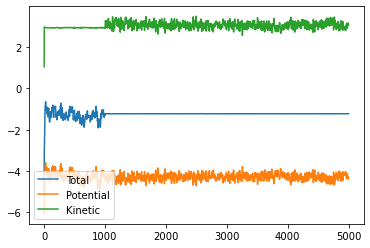

In [69]:
skip = 1
plt.plot(traj_totnrg[skip:], label='Total')
plt.plot(traj_potnrg[skip:], label='Potential')
plt.plot(traj_kinnrg[skip:], label='Kinetic')
plt.legend()

Let's plot the temperature fluctuations now ...

Average kT =  2.0360011749432783


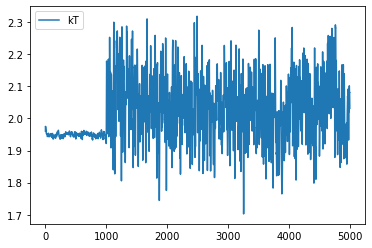

In [73]:
# Compute the average kT AFTER equilibration phase ...
print("Average kT = ", kT[1000:].mean())

skip = 2
plt.plot(kT[skip:], label='kT')
plt.legend()

## Radial Distribution Function (RDF)

In [74]:
@jit(nopython=True)
def RDF(pos,boxl,bw=0.01):
    steps = pos.shape[0]
    npart = pos.shape[1]
    ndim = pos.shape[2]

    rho = npart/(boxl**ndim)
    
    nbins = int(boxl/(2*bw))
    rdf = np.zeros(nbins)
    rbins = np.linspace(0,boxl/2,nbins) # Create grid/bins for r
    
    for step in range(steps):
        for i in range(npart):
            for j in range(npart):
                if i != j:
                    dpos = (pos[step][i]-pos[step][j])
                    # Perform transformation for minimum image convention (MIC)
                    for comp in range(len(dpos)):
                        if np.abs(dpos[comp]) > boxl/2.0:
                            dpos[comp] -= np.sign(dpos[comp])*boxl
                    r = np.linalg.norm(dpos)
                    if r <= boxl/2:
                        ibin = int(r / bw)
                        rdf[ibin] += 1
    if ndim == 3:
        rdf[1:] /= (4 * np.pi * rbins[1:]**2 * bw * rho * steps * npart) # for 3D RDF
    elif ndim == 2:
        rdf[1:] /= (2 * np.pi * rbins[1:] * bw * rho * steps * npart) # for 2D RDF
    else:
        print("Dimensionality not supported!")
        return None
    return rbins[1:], rdf[1:]

Let's calculate the RDF from this simulation run ... 

But, it will take a while! Note the "In [*]" sign on the left of the running cell indicating the job is still running!

In [75]:
rbins, rdf = RDF(traj_pos,boxl,bw=0.02)

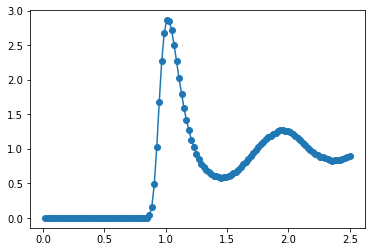

In [76]:
plt.plot(rbins, rdf,'-o')

You may vary the density, temperature to see how the local structural order vary from liquid to gas phase ...

It would be your task to compute the:
(i) Equation of state (P vesus density)
(ii) Diffusion constant from mean square displacement and velocity autocorrelation function
(iii) Autocorrelation function of potential energy ....

etc.